In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import FortranFile
import glob
import ipywidgets as widgets

import MIMutils

%matplotlib inline

# Examples for n layer model

This notebook contains several example runs of the n layer version of the model. They're in separate folders. Any line of code that starts with an exclamation mark (!) is executed by the terminal, not the python kernel.

## Hints
* The size of the grid (nx,ny,layers) must be specified when the code is compiled. Everything else is specified in parameters.in and can be varied at runtime. This means that the same binary file can be used to perform multiple simulations.
* Variable order is z,y,x

## f-plane at rest


Boring simulation, but shows that the model is stable.

Let's use:
* nx = 100
* ny = 100
* layers = 2

In [2]:
os.chdir('n_layer/f_plane/')

In [3]:
os.chdir('input/')


In [4]:
nx = 100
ny = 100
nz = 2
dx = 2e4
dy = 2e4

grid = MIMutils.Grid(nx,ny,dx,dy)


fu = np.ones((nx+1,ny), dtype=np.float64)*10e-4
fv = np.ones((nx,ny+1), dtype=np.float64)*10e-4

f = FortranFile('fu.bin', 'w')
f.write_record(fv)
f.close()

f = FortranFile('fv.bin', 'w')
f.write_record(fv)
f.close()

wetmask = np.ones((ny,nx), dtype=np.float64)
wetmask[0,:] = 0
wetmask[-1,:] = 0
wetmask[:,0] = 0
wetmask[:,-1] = 0

f = FortranFile('wetmask.bin', 'w')
f.write_record(wetmask)
f.close()

initH = np.ones((nz,ny,nx))
initH[0,:,:] = 400
initH[1,:,:] = 2000 - initH[0,:,:]


f = FortranFile('initH.bin', 'w')
f.write_record(initH)
f.close()



In [5]:
os.chdir('../')

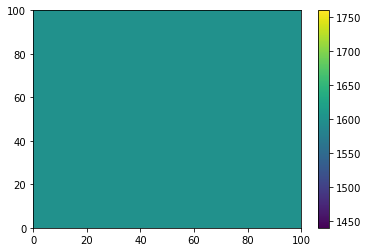

In [6]:
f = FortranFile('output/snap.h.0000000001')
#f = FortranFile('input/initH.bin')
h_init = f.read_reals('d')
h_init = h_init.reshape(nz,ny,nx)
f.close()

#h_init = np.fromfile('input/initH.bin','<f8')
#h_init = h_init.reshape(nz,ny+1,nx+1)

f = FortranFile('output/snap.h.0000000061')
h_final = f.read_record(dtype=np.float64).reshape(nz,ny,nx)
f.close()

plt.pcolormesh(h_final[1,:,:])
plt.colorbar()

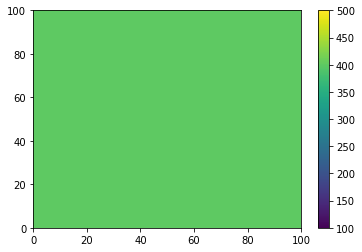

In [7]:
plt.pcolormesh(h_init[0,:,:],vmin=100,vmax = 500)
plt.colorbar()

In [8]:
os.chdir('../')

### $\beta $-plane with a Gaussian bump 

Slightly more exciting. Initialise a bump in the thickness field on a $\beta $-plane and let it go.

Let's use:
* nx = 100
* ny = 100
* layers = 2
* dx = 1e4
* dy = 1e4
* Lx = 1e6
* Ly = 1e6

In [9]:
os.chdir('beta_plane_bump/')

In [10]:
os.chdir('input/')

In [11]:
nx = 100
ny = 100
nz = 2
dx = 1e4
dy = 1e4
Lx = 1e6
Ly = 1e6

grid = MIMutils.Grid(nx,ny,dx,dy)

f0 = 1e-5
beta = 2e-11

X,Y = np.meshgrid(grid.xp1,grid.y)
fu = f0 + Y*beta
X,Y = np.meshgrid(grid.x,grid.yp1)
fv = f0 + Y*beta

f = FortranFile('fu.bin', 'w')
f.write_record(fu.astype(np.float64))
f.close()

f = FortranFile('fv.bin', 'w')
f.write_record(fv.astype(np.float64))
f.close()

wetmask = np.ones((nx,ny), dtype=np.float64)
wetmask[0,:] = 0
wetmask[-1,:] = 0
wetmask[:,0] = 0
wetmask[:,-1] = 0

f = FortranFile('wetmask.bin', 'w')
f.write_record(wetmask.astype(np.float64))
f.close()

X,Y = np.meshgrid(grid.x,grid.y)

initH = np.ones((nz,ny,nx))
initH[0,:,:] = 500. + 20*np.exp(-((6e5-X)**2 + (5e5-Y)**2)/(2*1e5**2))
initH[1,:,:] = 2000. - initH[0,:,:]


f = FortranFile('initH.bin', 'w')
f.write_record(initH.astype(np.float64))
f.close()

In [12]:
os.chdir('../')

In [13]:
# Upper layer

u_files = sorted(glob.glob('output/snap.u.*'))
h_files = sorted(glob.glob('output/snap.h.*'))
eta_files = sorted(glob.glob('output/snap.eta.*'))
v_files = sorted(glob.glob('output/snap.v.*'))

X_u,Y_u = np.meshgrid(grid.xp1,grid.y)
X_h,Y_h = np.meshgrid(grid.x,grid.y)

def plt_upper_layer(counter):
    f = FortranFile(u_files[counter])
    u = f.read_record(dtype=np.float64).reshape(nz,ny,nx+1)
    f.close()
    
    f = FortranFile(h_files[counter])
    h = f.read_record(dtype=np.float64).reshape(nz,ny,nx)
    f.close()
    
    plt.figure()
    plt.title(u_files[counter])
    plt.pcolormesh(X_u/1e3,Y_u/1e3,u[0,:,:],vmin=-5e-2,vmax=5e-2,cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,h[0,:,:]-500,np.arange(-21,20,2),colors='k')
    
    
def plt_lower_layer(counter):
    f = FortranFile(u_files[counter])
    u = f.read_record(dtype=np.float64).reshape(nz,ny,nx+1)
    f.close()
    
    f = FortranFile(h_files[counter])
    h = f.read_record(dtype=np.float64).reshape(nz,ny,nx)
    f.close()
    
    plt.figure()
    plt.title(u_files[counter])
    plt.pcolormesh(X_u/1e3,Y_u/1e3,u[1,:,:],vmin=-5e-2,vmax=5e-2,cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,h[1,:,:]-1500,np.arange(-21,20,2),colors='k')

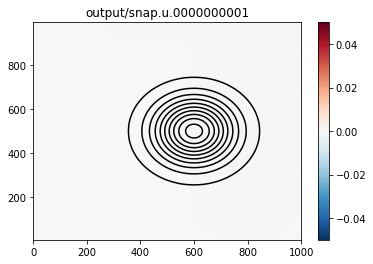

In [14]:
widgets.interact(plt_upper_layer,counter = widgets.IntSlider(min=0,max=len(u_files)));

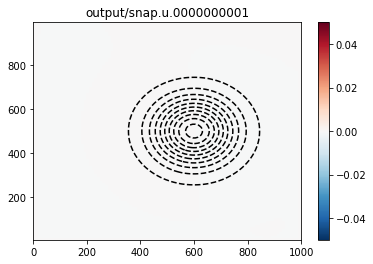

In [15]:
# Lower layer
widgets.interact(plt_lower_layer,counter=widgets.IntSlider(min=0,max=len(u_files)));

In [16]:
os.chdir('../')

# Twin-gyre on a $\beta$-plane domain with boundary conditions

This time we'll add some wind forcing and play with the boundary condition. This shows how the same compiled file can be used for different simulations. We change the value of 'slip' in parameters.in and rerun the model.

Let's use:
* nx = 100
* ny = 200
* layers = 1
* dx = 1e4
* dy = 1e4
* Lx = 1e6
* Ly = 2e6

In [17]:
os.chdir('beta_plane_gyre/')

In [18]:
os.chdir('input/')

In [19]:
nx = 100
ny = 200
nz = 2
dx = 1e4
dy = 1e4
Lx = 1e6
Ly = 2e6


grid = MIMutils.Grid(nx,ny,dx,dy)

f0 = 1e-5
beta = 2e-11

X,Y = np.meshgrid(grid.x,grid.yp1)
fv = f0 + Y*beta
X,Y = np.meshgrid(grid.xp1,grid.y)
fu = f0 + Y*beta

f = FortranFile('fu.bin', 'w')
f.write_record(fu.astype(np.float64))
f.close()

f = FortranFile('fv.bin', 'w')
f.write_record(fv.astype(np.float64))
f.close()

wetmask = np.ones((ny,nx), dtype=np.float64)
wetmask[0,:] = 0
wetmask[-1,:] = 0
wetmask[:,0] = 0
wetmask[:,-1] = 0

#wetmask[np.sin(np.pi*Y/2e6)]

f = FortranFile('wetmask.bin', 'w')
f.write_record(wetmask.astype(np.float64))
f.close()

X,Y = np.meshgrid(grid.x,grid.y)

initH = np.ones((nz,ny,nx))
initH[0,:,:] = 600. 
initH[1,:,:] = 2000. - initH[0,:,:]

f = FortranFile('initH.bin', 'w')
f.write_record(initH.astype(np.float64))
f.close()

X,Y = np.meshgrid(grid.xp1,grid.y)
wind_x = 0.05*(1-np.cos(2*np.pi*Y/np.max(grid.y)))
f = FortranFile('wind_x.bin', 'w')
f.write_record(wind_x.astype(np.float64))
f.close()

In [20]:
print wind_x.shape
print fu.shape
print fv.shape

(200, 101)
(200, 101)
(201, 100)


In [21]:
os.chdir('../')

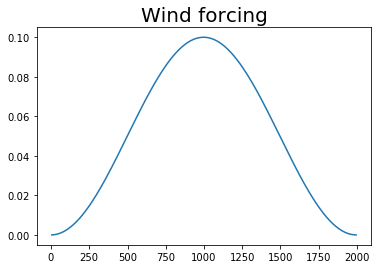

In [22]:
plt.plot(grid.y/1e3,wind_x[:,1])
plt.title('Wind forcing',fontsize=20);

## No Slip

In [23]:
os.chdir('no_slip/')

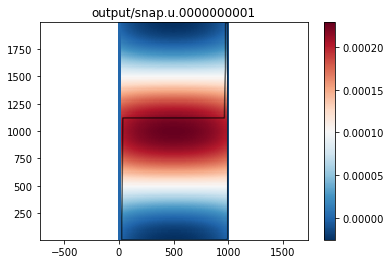

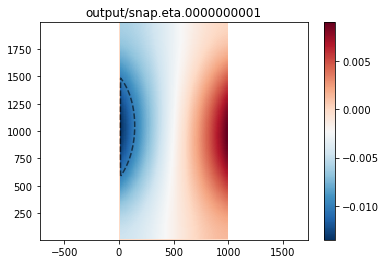

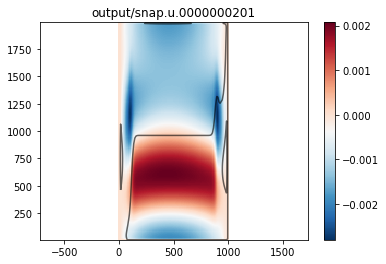

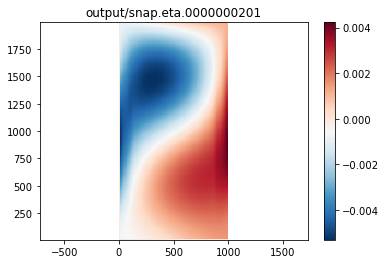

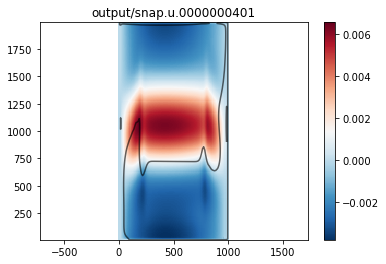

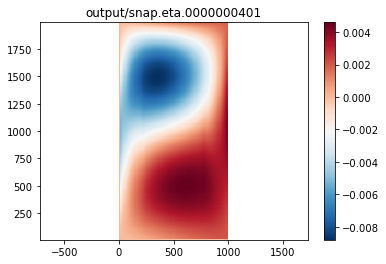

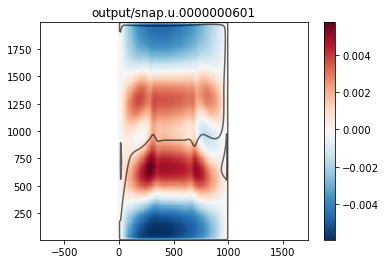

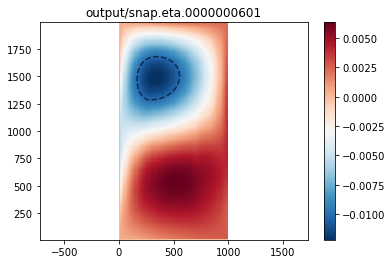

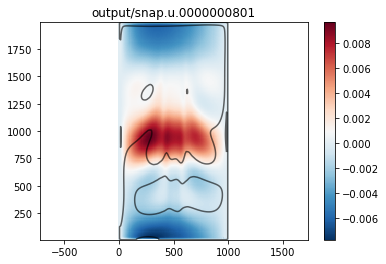

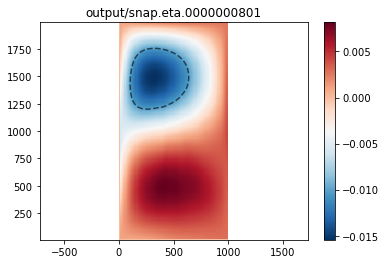

In [24]:
u_files = sorted(glob.glob('output/snap.u.*'))
#u_files.pop(0)
h_files = sorted(glob.glob('output/snap.h.*'))
#h_files.pop(0)
eta_files = sorted(glob.glob('output/snap.eta.*'))
#eta_files.pop(0)

X_u,Y_u = np.meshgrid(grid.xp1,grid.y)
X_h,Y_h = np.meshgrid(grid.x,grid.y)

for counter,udata_file in enumerate(u_files):
    
    f = FortranFile(h_files[counter], mode = 'r')
    h = f.read_reals('d')
    h = h.reshape(nz, ny, nx)
    f.close()   
    
    f = FortranFile(eta_files[counter], mode = 'r')
    eta = f.read_reals('d')
    eta = eta.reshape(1, ny, nx)
    f.close()
    
    
    f = FortranFile(udata_file,mode = 'r')
    u = f.read_reals('d')
    u = u.reshape(nz,ny,nx+1)
    
    plt.figure()
    plt.axes().set_aspect('equal', 'datalim')
    plt.title(udata_file)
    plt.pcolormesh(X_u/1e3,Y_u/1e3,(u[0,:,:]),cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,(h[0,:,:]),np.arange(100,800,1),colors='k',alpha=0.6)
    
    plt.figure()
    plt.axes().set_aspect('equal', 'datalim')
    plt.title(eta_files[counter])
    plt.pcolormesh(X_h/1e3,Y_h/1e3,(eta[0,:,:]),cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,(eta[0,:,:]),np.linspace(-1,1,100),colors='k',alpha=0.6)



In [25]:
os.chdir('../')

## Free-slip

In [26]:
os.chdir('free_slip/')

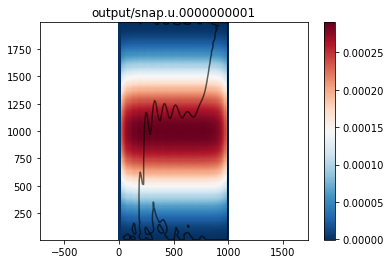

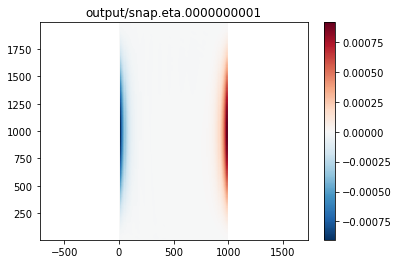

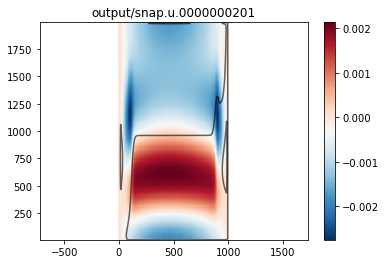

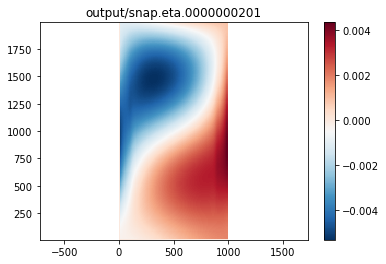

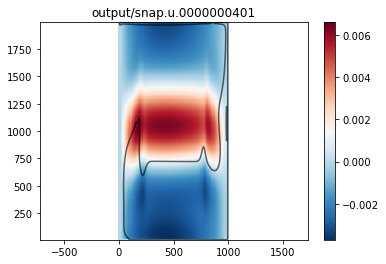

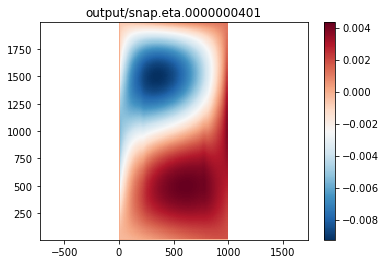

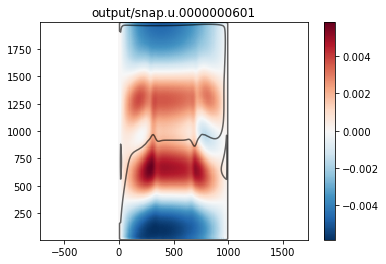

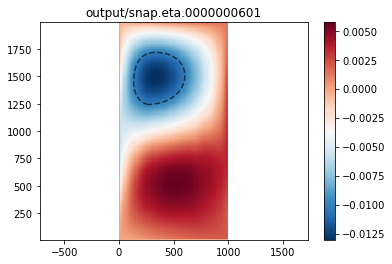

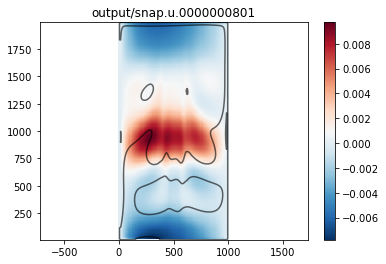

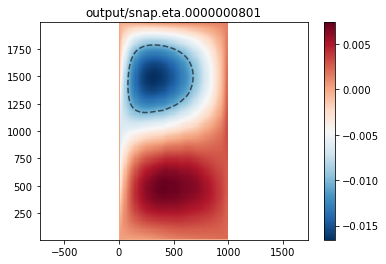

In [27]:
u_files = sorted(glob.glob('output/snap.u.*'))
#u_files.pop(0)
h_files = sorted(glob.glob('output/snap.h.*'))
#h_files.pop(0)
eta_files = sorted(glob.glob('output/snap.eta.*'))
#eta_files.pop(0)

X_u,Y_u = np.meshgrid(grid.xp1,grid.y)
X_h,Y_h = np.meshgrid(grid.x,grid.y)

for counter,udata_file in enumerate(u_files):
    
    f = FortranFile(h_files[counter], mode = 'r')
    h = f.read_reals('d')
    h = h.reshape(nz, ny, nx)
    f.close()   
    
    f = FortranFile(eta_files[counter], mode = 'r')
    eta = f.read_reals('d')
    eta = eta.reshape(1, ny, nx)
    f.close()
    
    
    f = FortranFile(udata_file,mode = 'r')
    u = f.read_reals('d')
    u = u.reshape(nz,ny,nx+1)
    
    plt.figure()
    plt.axes().set_aspect('equal', 'datalim')
    plt.title(udata_file)
    plt.pcolormesh(X_u/1e3,Y_u/1e3,(u[0,:,:]),cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,(h[0,:,:]),np.arange(100,800,1),colors='k',alpha=0.6)
    
    plt.figure()
    plt.axes().set_aspect('equal', 'datalim')
    plt.title(eta_files[counter])
    plt.pcolormesh(X_h/1e3,Y_h/1e3,(eta[0,:,:]),cmap='RdBu_r')
    plt.colorbar()
    plt.contour(X_h/1e3,Y_h/1e3,(eta[0,:,:]),np.linspace(-1,1,100),colors='k',alpha=0.6)



In [28]:
os.chdir('../')